<a href="https://colab.research.google.com/github/nelslindahlx/KnowledgeReduce/blob/main/CivicHonorsKGv12_Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code Summary

The code developed for execution in Google Colab represents a comprehensive workflow for extracting, processing, and organizing data from a website into a knowledge graph. Here's a summary of each step in the code:

### Step 1: Install Necessary Libraries
- Installs the required Python libraries: `requests` for web scraping, `beautifulsoup4` for HTML parsing, `networkx` for graph operations, and `spacy` for natural language processing.

### Step 2: Import Libraries and Define Classes
- Imports essential Python modules and defines two classes:
  - `ReliabilityRating`: An enumeration (Enum) for categorizing the reliability of facts.
  - `KnowledgeGraph`: A class for creating and managing a knowledge graph, including methods for adding facts, calculating quality scores, updating these scores, and retrieving facts.

### Step 3: Scrape Data from the Website
- Fetches and parses the HTML content of a specified website, extracting text data from common HTML elements like paragraphs, headings, and lists.

### Step 4: Store Extracted Data in the KnowledgeGraph
- Initializes an instance of the `KnowledgeGraph`.
- Stores each extracted fact as a node in the graph with attributes such as fact statement, category, tags, etc.

### Step 5: Retrieve and Display 10 Facts
- Displays the first 10 facts from the knowledge graph, giving an overview of the extracted data, and prints the total number of facts extracted.

### Step 6: Store the KnowledgeGraph in GEXF and GraphML Formats
- Saves the graph in GEXF and GraphML file formats, suitable for analysis and visualization in various graph analysis tools.

### Step 7: Ensure Uniqueness of Facts in the Dataset
- Removes duplicate facts from the knowledge graph based on their statements to maintain data uniqueness.

### Step 8: Advanced Cleaning and Combining of Facts
- Implements advanced cleaning techniques, such as removing very short facts and deduplicating semantically similar facts using basic string comparison.

### Step 9: Super Aggressive Advanced Cleaning (Refined)
- Employs the `en_core_web_md` spaCy model for NLP tasks.
- Removes facts based on complex criteria, like semantic similarity, using NLP techniques to refine the dataset's quality further.

### Step 10: Store the Updated KnowledgeGraph in GEXF and GraphML Formats
- Saves the graph again in GEXF and GraphML file formats.

### Step 11: Serialization and deserialization of the KnowledgeGraph for portability.
- This step focuses on making the Knowledge Graph portable by serializing it into a JSON format. This allows for easy storage, transfer, and reconstruction of the graph in different environments. The process includes functions for both serialization and deserialization of the graph.

### Step 12: Graph Analysis Features
- This step focuses on adding graph analysis features to the Knowledge Graph. It includes functions for calculating various centrality measures, community detection, and other relevant graph analysis metrics. These features can provide valuable insights into the structure and characteristics of the graph.

This complete workflow effectively extracts information from a website, transforming it into a structured and clean dataset within a knowledge graph. It's particularly useful in scenarios where data quality, structure, and semantic richness are crucial. The inclusion of advanced NLP techniques in the later steps ensures a high-quality dataset, free from redundancies and rich in diverse information.

# Step 1: Install Necessary Libraries

In [1]:
# Completeness check passed
!pip install requests beautifulsoup4 networkx spacy
!python -m spacy download en_core_web_md


2023-12-28 15:23:58.140968: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-28 15:23:58.141040: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-28 15:23:58.142557: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-28 15:23:58.151411: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-28 15:23:59.443851: W tensorflow/compiler/tf2

# Step 2: Import Libraries and Define Classes

In [2]:
# Completeness check passed
# Importing necessary libraries
import requests
from bs4 import BeautifulSoup
import networkx as nx
from datetime import datetime
from enum import Enum
import difflib
import spacy
import matplotlib.pyplot as plt
import json

class ReliabilityRating(Enum):
    UNVERIFIED = 1
    POSSIBLY_TRUE = 2
    LIKELY_TRUE = 3
    VERIFIED = 4

class KnowledgeGraph:
    def __init__(self):
        self.graph = nx.DiGraph()

    def calculate_quality_score(self, reliability_rating, usage_count):
        # Adjusted to handle string representation of Enum
        rating_value = ReliabilityRating[reliability_rating].value if isinstance(reliability_rating, str) else reliability_rating.value
        base_score = 10 * rating_value
        usage_bonus = 2 * usage_count
        return base_score + usage_bonus

    def add_fact(self, fact_id, fact_statement, category, tags, date_recorded, last_updated,
                 reliability_rating, source_id, source_title, author_creator,
                 publication_date, url_reference, related_facts, contextual_notes,
                 access_level, usage_count):
        # Convert list and datetime objects to strings
        tags_str = ', '.join(tags) if tags else ''
        date_recorded_str = date_recorded.isoformat() if isinstance(date_recorded, datetime) else date_recorded
        last_updated_str = last_updated.isoformat() if isinstance(last_updated, datetime) else last_updated
        publication_date_str = publication_date.isoformat() if isinstance(publication_date, datetime) else publication_date

        quality_score = self.calculate_quality_score(reliability_rating, usage_count)
        self.graph.add_node(fact_id,
                            fact_statement=fact_statement,
                            category=category,
                            tags=tags_str,
                            date_recorded=date_recorded_str,
                            last_updated=last_updated_str,
                            reliability_rating=reliability_rating,
                            quality_score=quality_score,
                            source_id=source_id,
                            source_title=source_title,
                            author_creator=author_creator,
                            publication_date=publication_date_str,
                            url_reference=url_reference,
                            contextual_notes=contextual_notes,
                            access_level=access_level,
                            usage_count=usage_count)

        for related_fact_id in related_facts:
            self.graph.add_edge(fact_id, related_fact_id)

    def update_quality_score(self, fact_id):
        if fact_id not in self.graph:
            raise ValueError("Fact ID not found in the graph.")
        fact = self.graph.nodes[fact_id]
        new_score = self.calculate_quality_score(fact['reliability_rating'], fact['usage_count'])
        self.graph.nodes[fact_id]['quality_score'] = new_score

    def get_fact(self, fact_id):
        if fact_id not in self.graph:
            raise ValueError("Fact ID not found in the graph.")
        return self.graph.nodes[fact_id]

# Step 3: Scrape Data from the Website

In [3]:
# Completeness check passed
# Importing necessary libraries
# Fetch data from the website
url = "https://civichonors.com/"
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Function to extract text from a soup object
def extract_text(element):
    return ' '.join(element.stripped_strings)

# Generic function to find facts in common HTML structures
def find_facts(soup):
    facts = []

    # Look for paragraphs
    for p in soup.find_all('p'):
        text = extract_text(p)
        if text: facts.append(text)

    # Look for headings
    for header_tag in ['h1', 'h2', 'h3', 'h4', 'h5', 'h6']:
        for header in soup.find_all(header_tag):
            text = extract_text(header)
            if text: facts.append(text)

    # Look for list items
    for li in soup.find_all('li'):
        text = extract_text(li)
        if text: facts.append(text)

    return facts

# Extract facts using the generic function
facts = find_facts(soup)

# Step 4: Store Extracted Data in the KnowledgeGraph

In [4]:
# Completeness check passed
# Importing necessary libraries
# Initialize the KnowledgeGraph
kg = KnowledgeGraph()

# Store each fact in the KnowledgeGraph
for i, fact in enumerate(facts):
    kg.add_fact(
        fact_id=str(i),
        fact_statement=fact,
        category="General",
        tags=["CivicHonors", "WebScraped"],
        date_recorded=datetime.now(),
        last_updated=datetime.now(),
        reliability_rating=ReliabilityRating.LIKELY_TRUE.name,
        source_id="CivicHonors",
        source_title="Civic Honors Website",
        author_creator="Web Scraping",
        publication_date=datetime.now(),
        url_reference=url,
        related_facts=[],
        contextual_notes="Extracted from Civic Honors website",
        access_level="Public",
        usage_count=0
    )

# Step 5: Retrieve and Display 10 Facts

In [5]:
# Completeness check passed
# Print the total number of facts extracted
total_facts = len(facts)
print(f"Total facts extracted: {total_facts}")

# Retrieve and display up to 10 facts
for i in range(min(10, total_facts)):
    fact_id = str(i)
    try:
        fact = kg.get_fact(fact_id)
        print(f"Fact {i+1}: {fact}")
    except ValueError as e:
        print(f"Fact {i+1}: {str(e)}")
        break  # Stop the loop if a fact ID is not found

Total facts extracted: 310
Fact 1: {'fact_statement': 'Civic Honors', 'category': 'General', 'tags': 'CivicHonors, WebScraped', 'date_recorded': '2023-12-28T15:24:30.935553', 'last_updated': '2023-12-28T15:24:30.935559', 'reliability_rating': 'LIKELY_TRUE', 'quality_score': 30, 'source_id': 'CivicHonors', 'source_title': 'Civic Honors Website', 'author_creator': 'Web Scraping', 'publication_date': '2023-12-28T15:24:30.935571', 'url_reference': 'https://civichonors.com/', 'contextual_notes': 'Extracted from Civic Honors website', 'access_level': 'Public', 'usage_count': 0}
Fact 2: {'fact_statement': 'Graduation with Civic Honors: Unlock the Power of  Community Opportunity', 'category': 'General', 'tags': 'CivicHonors, WebScraped', 'date_recorded': '2023-12-28T15:24:30.935623', 'last_updated': '2023-12-28T15:24:30.935624', 'reliability_rating': 'LIKELY_TRUE', 'quality_score': 30, 'source_id': 'CivicHonors', 'source_title': 'Civic Honors Website', 'author_creator': 'Web Scraping', 'public

# Step 6: Store the KnowledgeGraph in GEXF and GraphML Formats

In [6]:
# Completeness check passed
# Store the graph in GEXF format
gexf_path = '/content/knowledge_graph.gexf'
nx.write_gexf(kg.graph, gexf_path)
print(f"Graph stored in GEXF format at: {gexf_path}")

# Store the graph in GraphML format
graphml_path = '/content/knowledge_graph.graphml'
nx.write_graphml(kg.graph, graphml_path)
print(f"Graph stored in GraphML format at: {graphml_path}")

Graph stored in GEXF format at: /content/knowledge_graph.gexf
Graph stored in GraphML format at: /content/knowledge_graph.graphml


# Step 7: Ensure Uniqueness of Facts in the Dataset

In [7]:
# Completeness check passed
def remove_duplicate_facts(knowledge_graph):
    unique_facts = set()
    nodes_to_remove = []

    for fact_id, fact_data in knowledge_graph.graph.nodes(data=True):
        fact_statement = fact_data['fact_statement']
        if fact_statement in unique_facts:
            nodes_to_remove.append(fact_id)
        else:
            unique_facts.add(fact_statement)

    # Remove duplicate nodes
    for fact_id in nodes_to_remove:
        knowledge_graph.graph.remove_node(fact_id)

    print(f"Removed {len(nodes_to_remove)} duplicate facts.")

# Call the function to remove duplicate facts
remove_duplicate_facts(kg)

# Optional: Print the total number of unique facts remaining
print(f"Total unique facts remaining: {kg.graph.number_of_nodes()}")

Removed 0 duplicate facts.
Total unique facts remaining: 310


# Step 8: Advanced Cleaning and Combining of Facts

In [8]:
# Completeness check passed
def advanced_cleaning(knowledge_graph, similarity_threshold=0.8, short_fact_threshold=20):
    nodes_to_remove = []
    facts_processed = set()

    # Remove short facts
    for fact_id, fact_data in knowledge_graph.graph.nodes(data=True):
        if len(fact_data['fact_statement']) < short_fact_threshold:
            nodes_to_remove.append(fact_id)
            continue

        # Check for similarity with already processed facts
        for processed_fact in facts_processed:
            similarity = difflib.SequenceMatcher(None, fact_data['fact_statement'], processed_fact).ratio()
            if similarity > similarity_threshold:
                nodes_to_remove.append(fact_id)
                break

        facts_processed.add(fact_data['fact_statement'])

    # Further custom strategies can be added here

    # Remove identified nodes
    for fact_id in nodes_to_remove:
        knowledge_graph.graph.remove_node(fact_id)

    print(f"Removed {len(nodes_to_remove)} facts based on advanced cleaning criteria.")

# Call the function for advanced cleaning
advanced_cleaning(kg)

# Optional: Print the total number of facts after cleaning
print(f"Total facts after advanced cleaning: {kg.graph.number_of_nodes()}")

Removed 5 facts based on advanced cleaning criteria.
Total facts after advanced cleaning: 305


# Step 9: Super Aggressive Advanced Cleaning (Refined)

In [9]:
# Completeness check passed
# Load the medium-sized English language model with word vectors
nlp = spacy.load("en_core_web_md")

def super_aggressive_cleaning(knowledge_graph, similarity_threshold=0.85):
    nodes_to_remove = set()
    facts_content = {}

    # Pre-process and store spaCy Doc objects for each fact
    for fact_id, fact_data in knowledge_graph.graph.nodes(data=True):
        try:
            doc = nlp(fact_data['fact_statement'])
            facts_content[fact_id] = doc
        except Exception as e:
            print(f"Error processing fact ID {fact_id}: {str(e)}")

    # Compare each fact with others for semantic similarity
    for fact_id, doc in facts_content.items():
        # Skip if already marked for removal
        if fact_id in nodes_to_remove:
            continue

        for other_fact_id, other_doc in facts_content.items():
            if fact_id != other_fact_id and other_fact_id not in nodes_to_remove:
                similarity = doc.similarity(other_doc)
                if similarity > similarity_threshold:
                    nodes_to_remove.add(other_fact_id)

    # Remove identified nodes
    for fact_id in nodes_to_remove:
        knowledge_graph.graph.remove_node(fact_id)

    print(f"Removed {len(nodes_to_remove)} facts based on super aggressive cleaning criteria.")

# Call the function for super aggressive cleaning
super_aggressive_cleaning(kg)

# Print the total number of facts after super aggressive cleaning
print(f"Total facts after super aggressive cleaning: {kg.graph.number_of_nodes()}")


Removed 268 facts based on super aggressive cleaning criteria.
Total facts after super aggressive cleaning: 37


# Step 10: Store the Updated KnowledgeGraph in GEXF and GraphML Formats

In [10]:
# Completeness check passed
# Store the graph in GEXF format
gexf_path = '/content/knowledge_graph2.gexf'
nx.write_gexf(kg.graph, gexf_path)
print(f"Graph stored in GEXF format at: {gexf_path}")

# Store the graph in GraphML format
graphml_path = '/content/knowledge_graph2.graphml'
nx.write_graphml(kg.graph, graphml_path)
print(f"Graph stored in GraphML format at: {graphml_path}")

Graph stored in GEXF format at: /content/knowledge_graph2.gexf
Graph stored in GraphML format at: /content/knowledge_graph2.graphml


## Step 11: Making the Knowledge Graph Portable

This step focuses on making the Knowledge Graph portable by serializing it into a JSON format. This allows for easy storage, transfer, and reconstruction of the graph in different environments. The process includes functions for both serialization and deserialization of the graph.

In [11]:
class KnowledgeGraphPortable:
    def __init__(self, knowledge_graph):
        # Assuming the NetworkX graph is stored in an attribute named 'graph' in KnowledgeGraph
        self.graph = knowledge_graph.graph

    def serialize_to_json(self, filepath):
        # Convert graph to a dictionary or suitable structure
        graph_data = nx.node_link_data(self.graph)
        with open(filepath, 'w') as file:
            json.dump(graph_data, file)
        print(f"Graph serialized and saved to {filepath}")

    def deserialize_from_json(self, filepath):
        # Read the file and convert it back to a graph
        with open(filepath, 'r') as file:
            graph_data = json.load(file)
        self.graph = nx.node_link_graph(graph_data)
        print(f"Graph deserialized from {filepath}")

# Usage
kg_portable = KnowledgeGraphPortable(kg)
kg_portable.serialize_to_json('path_to_graph.json')  # Serialize and save the graph
kg_portable.deserialize_from_json('path_to_graph.json')  # Deserialize the saved graph
print("Serialization and deserialization of Knowledge Graph completed successfully.")


Graph serialized and saved to path_to_graph.json
Graph deserialized from path_to_graph.json
Serialization and deserialization of Knowledge Graph completed successfully.


## Step 12: Graph Analysis Features

This step focuses on adding graph analysis features to the Knowledge Graph. It includes functions for calculating various centrality measures, community detection, and other relevant graph analysis metrics. These features can provide valuable insights into the structure and characteristics of the graph.

Starting graph analysis...
Calculated centrality measures.


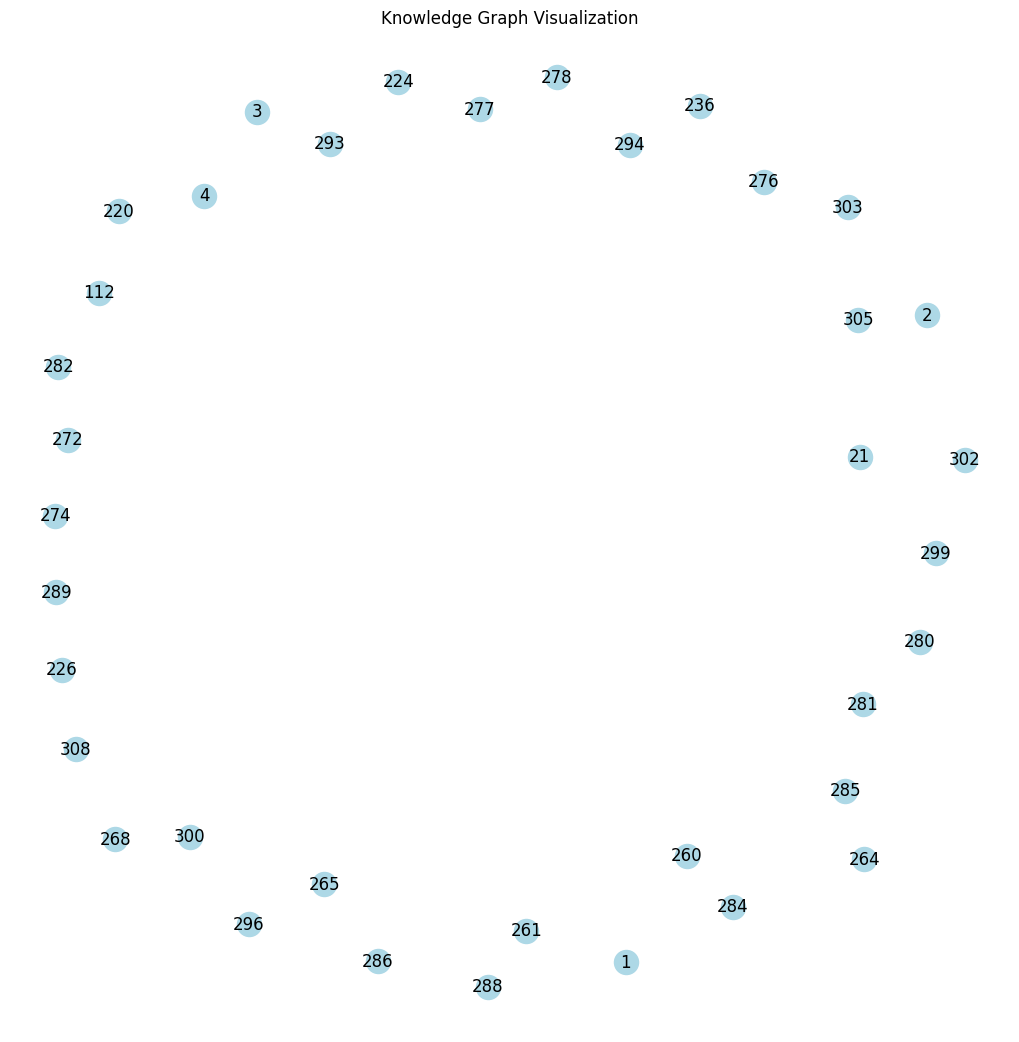

Graph visualization complete.


In [13]:
def analyze_graph(knowledge_graph):
    # Assuming the graph is stored in the 'graph' attribute of KnowledgeGraph
    G = knowledge_graph.graph

    print("Starting graph analysis...")

    # Calculate various centrality measures
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    print("Calculated centrality measures.")

    # Community detection (requires additional libraries like community or networkx algorithms)
    # communities = community.best_partition(G)
    # print("Detected communities in the graph.")

    # Example visualization (adjust as needed)
    plt.figure(figsize=(10, 10))
    nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray')
    plt.title('Knowledge Graph Visualization')
    plt.show()
    print("Graph visualization complete.")

    return {
        'degree_centrality': degree_centrality,
        'betweenness_centrality': betweenness_centrality,
        'closeness_centrality': closeness_centrality,
        # 'communities': communities
    }

# Usage
graph_analysis_results = analyze_graph(kg)
